# Supplemental Information:

> **"Clonal genetic heterogeneity influences the fate of new adaptive mutations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 3 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 3, S5 and S6 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import numpy as np
from scipy import stats
import pandas as pd # (*) Pandas for data manipulation

import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,utils,config

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

## Data import

### Chromosome length

In [2]:
chr_coords = utils.chr_coords()

chr_coords.head()

,chr_arabic,chr_length,chr_roman,chr_start,chr_end
0,1,230218,I,0,230218
1,2,813184,II,230218,1043402
2,3,316620,III,1043402,1360022
3,4,1531933,IV,1360022,2891955
4,5,576874,V,2891955,3468829


### Ancestral and evolved isolate genomes

* *De novo* SNPs and indels in ancestral and evolved isolate genomes

In [3]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df, chr_coords)

seq_mut_df = seq_mut_df[(seq_mut_df.clone!='')].reset_index(drop=True)

# remap genotype values
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0': 0, '1': 2,'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'snp_indel'

seq_mut_df.head()

,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chr_arabic,...,substitution,assignment,mutation_type,consequence_short,chr_roman_x,chr_length,chr_roman_y,pos,chr_roman,type
0,1,0.5,[A],2.0,A,R/I,protein_coding,1.723,101,7,...,C>A,bulk,driver,non-synonymous,VII,1090940,VII,4595191.0,VII,snp_indel
1,1,0.5,[C],2.0,NaN,NaN,NaN,-0.34,NaN,4,...,A>C,bulk,passenger,NaN,IV,1531933,IV,2849276.0,IV,snp_indel
2,1,0.5,[A],2.0,A,C/F,protein_coding,-1.488,1883,10,...,C>A,bulk,passenger,non-synonymous,X,745751,X,5980969.0,X,snp_indel
3,1,0.5,[T],2.0,NaN,NaN,NaN,-0.653,NaN,13,...,C>T,bulk,passenger,NaN,XIII,924431,XIII,8949297.0,XIII,snp_indel
4,1,0.5,[C],2.0,C,C/W,protein_coding,1.674,477,13,...,A>C,bulk,passenger,non-synonymous,XIII,924431,XIII,9157827.0,XIII,snp_indel


* Background (consensus) and *de novo* SNPs and indels
* Copy number variation
* Loss-of-heterozygosity

In [4]:
# load data
seq_loh_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_loh.pickle')

seq_loh_df.head()

,selection,population,sample,time,set,clone,lineage,type,chr_arabic,chr_roman,start,end,length,pos,genotype,ploidy,gene
65038,HU,WAxNA_F12_2_HU_3,WAxNA_F12_2_HU_3_T32_C5,32,7,5,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64830,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C1,32,7,1,bulk,copy_number,1,I,0,230218,NaN,0,2,diploid,
64846,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C2,32,8,2,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64862,RM,WAxNA_F12_1_RM_3,WAxNA_F12_1_RM_3_T32_C3,32,8,3,subclone A,copy_number,1,I,0,230218,NaN,0,2,diploid,
64894,HU,WAxNA_F12_2_HU_1,WAxNA_F12_2_HU_1_T32_C2,32,2,2,bulk,copy_number,1,I,0,230218,NaN,0,2,diploid,


Join all variants (SNPs, indels, LOH, copy number) into a single dataframe:

In [5]:
columns=['selection','population','clone']
seq_mut_fixed_df = pd.merge(seq_mut_df, 
                            seq_loh_df[['selection','population','clone','set','lineage']].drop_duplicates(columns), 
                            on=columns, how='left')
seq_loh_fixed_df = pd.merge(seq_loh_df, 
                            seq_mut_df[['selection','population','clone']].drop_duplicates(columns), 
                            on=columns, how='left')

seq_dn_df = pd.concat([seq_loh_fixed_df, seq_mut_fixed_df], axis=0).reset_index(drop=True)

seq_dn_df.head()

,ac,af,allele,alt,amino_acids,an,assignment,background,baseqranksum,biotype,...,species,start,str,strand,substitution,symbol_source,tag_1,tag_2,time,type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,32,copy_number


### Length distribution of homozygosity tracts

In [6]:
# load data
loh_length_df = pd.read_csv(dir_data+'seq/loh/homozygosity_length.tsv', sep='\t')
loh_length_df = loh_length_df.set_index("50kb_bin_center")
loh_length_df = loh_length_df.reindex(columns=['HU','RM','YPD'])

loh_length_df.head()

,HU,RM,YPD
50kb_bin_center,,,
25.0,0.731240,0.745737,0.749937
75.0,0.140123,0.153088,0.159649
125.0,0.053599,0.056461,0.053509
175.0,0.033691,0.021599,0.021700
225.0,0.013017,0.009852,0.008454


### Fluctuation assay

Luria-Delbrück fluctuation assay.

In [11]:
# read csv file containing the competition assay data
loh_fluctuation_df = pd.read_csv(dir_data+'fluctuation/fluctuation_assay.csv')

# dilution factors
loh_fluctuation_df['5-FOA_norm'] = loh_fluctuation_df['5-FOA']*200/10
loh_fluctuation_df['YPD_norm'] = loh_fluctuation_df['YPD']*1000000*2/40

# rate
loh_fluctuation_df['LOH rate'] = loh_fluctuation_df['5-FOA_norm']/loh_fluctuation_df['YPD_norm']

# loh_fluctuation_df = loh_fluctuation_df.groupby(['background','environment']).agg([np.mean, stats.sem])

# # order columns
# loh_fluctuation_df = loh_fluctuation_df.ix[['WA/WA','NA/NA','WA/NA']]
# loh_fluctuation_df = loh_fluctuation_df.unstack('background')

loh_fluctuation_df.head()

,background,biological_rep,technical_rep,environment,YPD,5-FOA,5-FOA_norm,YPD_norm,LOH rate
0,WA/WA,1,1,HU,4,94,1880.0,200000.0,0.009400
1,NA/NA,1,1,HU,45,467,9340.0,2250000.0,0.004151
2,WA/NA,1,1,HU,1,18,360.0,50000.0,0.007200
3,WA/WA,1,2,HU,4,111,2220.0,200000.0,0.011100
4,NA/NA,1,2,HU,66,463,9260.0,3300000.0,0.002806


In [14]:
loh_fluctuation_df.groupby(['background','environment'])[['5-FOA','YPD','5-FOA_norm','YPD_norm']].mean().reset_index()

,background,environment,5-FOA,YPD,5-FOA_norm,YPD_norm
0,NA/NA,HU,344.875,55.000,6897.5,2750000.0
1,NA/NA,RM,323.375,126.875,6467.5,6343750.0
2,NA/NA,YPD,55.875,102.875,1117.5,5143750.0
3,WA/NA,HU,34.250,4.750,685.0,237500.0
4,WA/NA,RM,8.250,73.250,165.0,3662500.0
5,WA/NA,YPD,8.750,84.750,175.0,4237500.0
6,WA/WA,HU,103.500,3.500,2070.0,175000.0
7,WA/WA,RM,97.625,116.625,1952.5,5831250.0
8,WA/WA,YPD,39.750,149.000,795.0,7450000.0


In [9]:
# loh_fluctuation_df.groupby(['background','environment'])['Total YPD'].mean()

## Figure 3 - Loss of heterozygosity

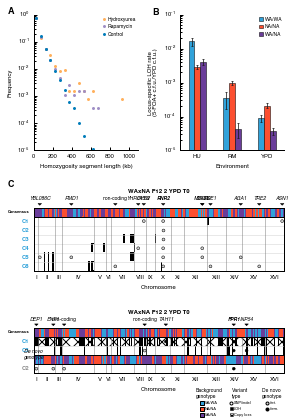

In [10]:
fig = plt.figure(figsize=(4,6))

grid = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[15, 7, 5], hspace=0.7, wspace=0.4)

gs = {}
gs['length'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,0])
gs['fluctuation'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0,1])
gs[('loh','WAxNA_F12_1_HU_3')] = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=grid[1:2,:], hspace=0)
gs[('loh','WAxNA_F12_2_RM_1')] = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=grid[2:3,:], hspace=0)

### top left panel ###
ax = plt.subplot(gs['length'][:])
ax.text(-0.185, 1.055, 'A', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

plot.loh_length(loh_length_df, ax)

### top right panel ###
ax = plt.subplot(gs['fluctuation'][:])
ax.text(-0.2, 1.05, 'B', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

plot.loh_fluctuation(loh_fluctuation_df, ax)

### bottom panel ###
seq_dn_df_sliced = pd.pivot_table(seq_dn_df, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

seq_dn_df_sliced = plot.filter_multiindex(seq_dn_df_sliced, names=['consensus','snp_indel','copy_number','loh'])

for ii, (e,p,t) in enumerate([('HU','WAxNA_F12_1_HU_3',32),('RM','WAxNA_F12_2_RM_1',32)]):
    ax = gs[('loh',p)]
    data = seq_dn_df_sliced.ix[e,p,t]

    plot.genome_instability(data, ax=ax, title='WAxNA F12 2 YPD T0')#p.replace('_',' ')+' T32')
    
# Set panel labels
ax = plt.subplot(gs[('loh','WAxNA_F12_1_HU_3')][0,0])

ax.text(-0.08, 4, 'C', transform=ax.transAxes,
        fontsize=9, fontweight='bold', va='top', ha='right')

# Set legend
ax = plt.subplot(gs[('loh','WAxNA_F12_2_RM_1')][3,0])

wa_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.background['color']['WA/WA'], marker='s', markersize=4, linestyle='')
na_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.background['color']['NA/NA'], marker='s', markersize=4, linestyle='')
het_artist = lines.Line2D((0,.75),(0,0), mec='k', mfc=config.background['color']['WA/NA'], marker='s', markersize=4, linestyle='')

leg1 = ax.legend([wa_artist,na_artist,het_artist], ['WA/WA','NA/NA','WA/NA'], 
                 bbox_to_anchor=(0.7, -2.5), ncol=1,
                 frameon=False, loc='upper center',
                 borderaxespad=0, handlelength=0.75, 
                 title='Background\ngenotype', prop={'size':4})

snp_indel_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][0], 
                                marker='o', markersize=3, linestyle='')
loh_artist = patches.Rectangle((0,0), width=1, height=1, color='k')
cn_loss_artist = patches.Rectangle((0,0), width=1, height=1, color='k', hatch='xxx', fill=False)
    
leg2 = ax.legend([snp_indel_artist,loh_artist,cn_loss_artist], 
                 ['SNP/indel','LOH','Copy loss'], 
                 bbox_to_anchor=(0.825, -2.5), ncol=1,
                 frameon=False, loc='upper center',
                 borderaxespad=0, handlelength=0.75, 
                 title='Variant\ntype', prop={'size':4})
    
het_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][1], 
                          marker='o', markersize=3, linestyle='')
hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                          marker='o', markersize=3, linestyle='')

leg3 = ax.legend([het_artist,hom_artist], ['het.','hom.'], 
                 bbox_to_anchor=(0.95, -2.5), ncol=1,
                 frameon=False, loc='upper center',
                 borderaxespad=0, handlelength=0.75, 
                 title='De novo\ngenotype', prop={'size':4, 'style':'italic'})

ax.add_artist(leg1)
ax.add_artist(leg2)

ax.annotate('De novo\ngenotype', xy=(-1,0.5),
            fontsize=5, va='bottom', ha='center',
            color='k', style='italic')
    
for leg in [leg1,leg2,leg3]:
    plt.setp(leg.get_title(),fontsize=5)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=3, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=2, labelsize=4)

plot.save_figure(dir_paper+'figures/figure3/figure3', formats=['pdf','png','svg'])
plt.show()

**Fig. 3:** Pervasive genome instability. (**A**) The length distribution of homozygous segments, in bins corresponding to 50-kb increments, shows an excess of long homozygosity tracts above 300 kb in hydroxyurea and rapamycin (KS-test, $P<0.01$). Ancestral haploid isolates are used to compare a set of *in silico* diploid genomes to evolved diploid isolates. Only unrelated isolate backgrounds were included. (**B**) Background- and environment-dependent rates of loss-of-heterozygosity were measured in a fluctuation assay by loss of the *URA3* marker. 5-FOA+ colonies indicate loss of the marker. LOH rates were elevated in hydroxyurea compared to the control environment and manifested background-dependent effects between the parents and their hybrid. The mean frequency of 5-FOA+ colony-forming units (c.f.u.) is shown. Error bars indicate the standard error of the mean. (**C**) Whole-genome sequences of evolved clones sampled from WAxNA F12 populations after 32 days in hydroxyurea (top) or rapamycin (bottom). Chromosomes are shown on the $x$-axis; clone isolates are listed on the left, colored by lineage (see Fig. S4). The consensus shows the majority genotype across isolates with sequence identity greater than 80%. Individual cells with a shared background genotype carry *de novo* SNPs and indels (circles), mis-segregations with loss-of-heterozygosity (solid segments) and copy-number changes (hatched segments). Driver and passenger mutations are listed along the top (drivers are in boldface). In hydroxyurea, each isolate carries a shared *RNR2* heterozygous mutation and private regions with LOH. Chromosome II has undergone extensive LOH in isolates C5 and C6, which have 13% faster growth rate compared to C1-C4 (Fig. 2D, center panel). In rapamycin, *FPR1* mutant clone C1 is haploid and is related to the diploid clone C3. Both have lost the remaining *FPR1* wild-type copy either by a localized LOH event (C3) or meiosis (C1). An extended version of the figure with all sequenced isolates can be found in Fig. S6.

## Figure S5 - Sequences of ancestral clones

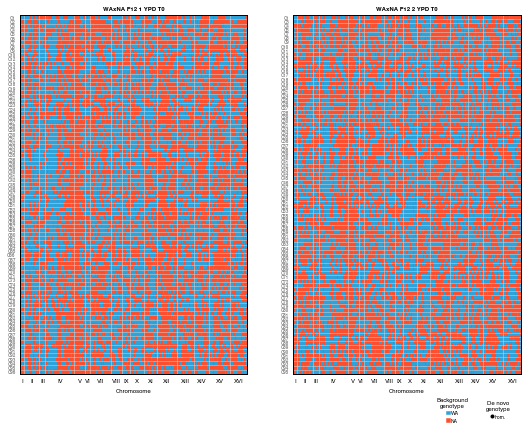

In [11]:
# keep ancestral haploid isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['genotype','de novo'])) & \
                             (seq_dn_df['time']==0) & \
                             (seq_dn_df['ploidy']=='haploid')]

seq_dn_df_sliced['clone'] = seq_dn_df_sliced['clone'].astype(int)
seq_dn_df_sliced = seq_dn_df_sliced.sort_values('clone')

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(8, 6))

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_sliced.groupby(level=['population'])
})

grid = gridspec.GridSpec(1, 2, wspace=0.2)
gs = {}

for ii, (p, sdf) in enumerate(seq_dn_df_sliced.groupby(level=['population'])):

    nrows = 1
    ncols = 1
    gs[p] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0, wspace=0)
    
    # retrieve axis
    ax = plt.subplot(gs[p][:])
    
    ### background genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['genotype']
    gt = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
            
    x = gt.columns.get_level_values('pos').values
    y = np.arange(len(gt.index))
    data = gt.fillna(method='pad', axis=1).values
        
    # make a color map of fixed colors
    cmap = plt.cm.colors.ListedColormap([config.background['color']['NA'], 
                                         config.background['color']['WA']])
    bounds = [0,1]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []
        
    plot.heatmap(np.r_[x, x.max()+1], np.r_[y, y.max()+1], data,
                 ax, title, xlabel, ylabel, xticklabels, yticklabels, cmap=cmap, 
                 vmin=np.nanmin(data), vmax=np.nanmax(data), speed='fast')

    # set title
    ax.set_title(p.replace('_',' ')+' T0', fontsize=6, weight='bold')
    
    # set ticks
    lineage = gt.index.get_level_values('lineage').unique()[0]
    ax.tick_params(axis='y', colors=config.lineages[lineage]['fill'], width=5, which='both')
    
    ### de novo genotype ###
    indexer = [slice(None)]*len(sdf.index.names)
    indexer[sdf.index.names.index('type')] = ['de novo']
    gn = sdf.loc[tuple(indexer),:].dropna(axis=1, how='all')
        
    if len(gn) > 0:
                
        for i,(k,g) in enumerate(gn.groupby(level='clone')):

            g = g.dropna(axis=1)
            x = g.columns.get_level_values('pos').values
            y = np.repeat(g.index.get_level_values('clone').values+.5, len(x))
            data = g.values.flatten()
            ax.scatter(x, y,
                       facecolors=[config.genotype['color'][d] for d in data],
                       edgecolors='lightgray', s=8, rasterized=False, zorder=3)
            
            genes = g.columns.get_level_values('gene')
            loc = zip(x, y-.4)
            
            for l, xy in zip(genes, loc):

                ann = ax.annotate(l, xy=xy, xytext=(0, 0), textcoords='offset points',
                                  bbox=dict(boxstyle="round,pad=0", fc="w", alpha=0.5),
                                  fontsize=4.5, va='bottom', ha='center',
                                  color='k', style=('italic' if l!='non-coding' else 'normal'),
                                  path_effects=[PathEffects.withStroke(linewidth=0.35, foreground='w')])

    # set grid
    xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
    xstart = chr_coords.chr_start
    ax.set_xticks(xlabels, minor=False)
    ax.set_xticklabels(chr_coords.chr_arabic.apply(utils.int_to_roman), minor=False)
    ax.set_xlabel('Chromosome')
    xgrid=[xst+1. for xst in list(set(xstart))]
    [ax.axvline(g, lw=0.5, ls="-", color="lightgray") for g in xgrid]
    
    ylabels = gt.index.get_level_values('clone').map(str)
    ax.set_yticks(np.arange(len(ylabels)) + 0.5, minor=False)
    ax.set_yticklabels('C' + ylabels, fontweight='bold', va='center', minor=False)
    [ax.axhline(g, lw=0.5, ls="-", color="lightgray") for g in np.arange(len(ylabels))]

# set legend
for k, xy in zip(['WAxNA_F12_2_YPD'],[(2,0),(2,0)]):
    
    ax = plt.subplot(gs[k][:])
    
    wt_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['WA'])
    hom_artist = patches.Rectangle((0,0), width=1, height=1, color=config.background['color']['NA'])
    
    leg1 = ax.legend([wt_artist,hom_artist], 
                     ['WA','NA'], 
                     bbox_to_anchor=(0.7, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='Background\ngenotype', prop={'size':5})
    
    hom_artist = lines.Line2D((0,1),(0,0), mec='k', mfc=config.genotype['color'][2],
                              marker='o', markersize=3, linestyle='')
    
    leg2 = ax.legend([hom_artist], 
                     ['hom.'], 
                     bbox_to_anchor=(0.9, -0.1), ncol=1,
                     frameon=False, loc='center',
                     borderaxespad=0, handlelength=0.75, 
                     title='De novo\ngenotype', prop={'size':5})
    
    ax.add_artist(leg1)
        
    for leg in [leg1,leg2]:
        plt.setp(leg.get_title(),fontsize=6, multialignment='center')

for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='x', which='major', size=2, labelsize=6)
    ax.tick_params(axis='y', which='major', size=2, labelsize=4.5)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

plot.save_figure(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_ancestral_clones')
plt.show()

**Fig. S5:** Sequences of ancestral clones sampled from the WAxNA $\text{F}_\text{12}$ founder populations, which were obtained by bulk crossing between the WA and NA parents. Pre-existing and *de novo* SNPs and indels were detected by whole-genome sequencing in single-cell derived clones from ancestral populations at ${t\,{=}\,0}$ days. Chromosomes are shown on the $x$-axis; clone isolates are listed on the left. WA (in blue) and NA (in red) represent haploid genotypes. Individual cells with unique background genotypes carry private *de novo* SNPs and indels (circles).

## Figure S6 - Genome instability in sequences of evolved clones

HU WAxNA_F12_1_HU_1 (8, 10733)
HU WAxNA_F12_1_HU_2 (7, 10733)
HU WAxNA_F12_1_HU_3 (19, 10733)
HU WAxNA_F12_2_HU_1 (8, 10733)
HU WAxNA_F12_2_HU_2 (14, 10733)
HU WAxNA_F12_2_HU_3 (20, 10733)
RM WAxNA_F12_1_RM_1 (11, 10733)
RM WAxNA_F12_1_RM_2 (22, 10733)
RM WAxNA_F12_1_RM_3 (11, 10733)
RM WAxNA_F12_2_RM_1 (11, 10733)
RM WAxNA_F12_2_RM_2 (22, 10733)
RM WAxNA_F12_2_RM_3 (4, 10733)


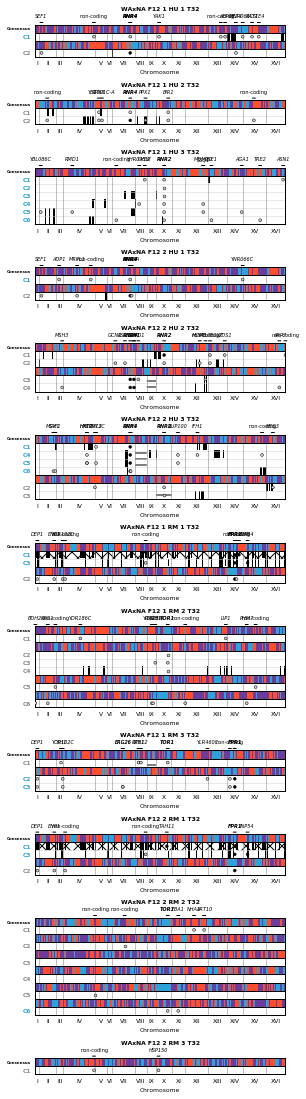

In [11]:
# Keep evolved isolates only
seq_dn_df_sliced = seq_dn_df[(seq_dn_df['type'].isin(['consensus','snp_indel','copy_number','loh'])) & \
                             (seq_dn_df['time']==32)]

seq_dn_df_sliced = pd.pivot_table(seq_dn_df_sliced, 
                                  index=['selection','population','time','set','clone','lineage','type','ploidy'], 
                                  columns=['chr_arabic','chr_roman','pos','gene'])['genotype']

fig = plt.figure(figsize=(4, 18))

indexer = [slice(None)]*len(seq_dn_df_sliced.index.names)
indexer[seq_dn_df_sliced.index.names.index('type')] = ['consensus','loh']
seq_dn_df_shape = seq_dn_df_sliced.loc[tuple(indexer),:].dropna(axis=1, how='all')

shape = pd.DataFrame({k: 
x.shape for k,x in seq_dn_df_shape.groupby(level=['selection','population'])
})

ygrid = shape.ix[0].values
grid = gridspec.GridSpec(len(ygrid), 1, height_ratios=ygrid, hspace=0.9)

gs = {}

for ii, ((e,p), data) in enumerate(seq_dn_df_sliced.groupby(level=['selection','population'])):

    idx = 0
    
    nrows = ygrid[ii]
    ncols = 1
    gs[(e,p)] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                                 subplot_spec=grid[ii],
                                                 hspace=0, wspace=0)
    
    ax = gs[(e,p)]
#     ax.text(-0.085, 1.2, 'C', transform=ax.transAxes,
#             fontsize=9, fontweight='bold', va='top', ha='right')
    print e, p, data.shape
    plot.genome_instability(data, ax=ax, title=p.replace('_',' ')+' T32')
    
#     if ax.is_first_row():
#         ax.text(-0.185, 1.055, 'A', transform=ax.transAxes,
#                 fontsize=9, fontweight='bold', va='top', ha='right')
    
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)

plot.save_figure(dir_supp+'figures/supp_figure_seq_clones/supp_figure_seq_evolved_clones')
plt.show()

**Fig. S6:** Genome instability in sequences of evolved clones. SNPs, indels and chromosome-level aberrations were detected by whole-genome sequencing in single-cell derived clones from evolved populations, after ${t\,{=}\,32}$ days in (**A**) hydroxurea or (**B**) rapamycin (see Table S1). Chromosomes are shown on the $x$-axis; clone isolates are listed on the left, colored by lineage (see Fig. S7). The consensus shows the majority genotype across population isolates with sequence identity greater than 80%. WA/WA (in blue) and NA/NA (in red) represent homozygous diploid genotypes and WA/NA (in purple) represents a heterozygous genotype. Individual cells with shared background genotype carry *de novo* SNPs and indels (circles), *de novo* mis-segregations with loss-of-heterozygosity (solid segments) and *de novo* gains or losses in copy number (hatched segments). Driver and passenger mutations are listed along the bottom (drivers are in boldface). Populations marked by $\otimes$ indicate cross-contamination during the selection phase, but any derived events are independent.